In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import seaborn as sns
import statistics

from impyute.imputation.cs import fast_knn
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder


import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.impute import KNNImputer

Highest Accuracy:


In [4]:
def get_datasets():
    train = pd.read_csv("train.csv")
    test = pd.read_csv("test.csv")
    return train, test
train, test = get_datasets()

In [4]:
print(train.shape)
train.head()

(318438, 18)


,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50


In [5]:
train.groupby("Stay")['case_id'].count()/len(train)*100

Stay
0-10                   7.412432
11-20                 24.538215
21-30                 27.475050
31-40                 17.321739
41-50                  3.687688
51-60                 10.996803
61-70                  0.861706
71-80                  3.220093
81-90                  1.519291
91-100                 0.868301
More than 100 Days     2.098682
Name: case_id, dtype: float64

In [6]:
train.isnull().sum()

case_id                                 0
Hospital_code                           0
Hospital_type_code                      0
City_Code_Hospital                      0
Hospital_region_code                    0
Available Extra Rooms in Hospital       0
Department                              0
Ward_Type                               0
Ward_Facility_Code                      0
Bed Grade                             113
patientid                               0
City_Code_Patient                    4532
Type of Admission                       0
Severity of Illness                     0
Visitors with Patient                   0
Age                                     0
Admission_Deposit                       0
Stay                                    0
dtype: int64

In [7]:
train.describe()

,case_id,Hospital_code,City_Code_Hospital,Available Extra Rooms in Hospital,Bed Grade,patientid,City_Code_Patient,Visitors with Patient,Admission_Deposit
count,318438.000000,318438.000000,318438.000000,318438.000000,318325.000000,318438.000000,313906.000000,318438.000000,318438.000000
mean,159219.500000,18.318841,4.771717,3.197627,2.625807,65747.579472,7.251859,3.284099,4880.749392
std,91925.276847,8.633755,3.102535,1.168171,0.873146,37979.936440,4.745266,1.764061,1086.776254
min,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1800.000000
25%,79610.250000,11.000000,2.000000,2.000000,2.000000,32847.000000,4.000000,2.000000,4186.000000
50%,159219.500000,19.000000,5.000000,3.000000,3.000000,65724.500000,8.000000,3.000000,4741.000000
75%,238828.750000,26.000000,7.000000,4.000000,3.000000,98470.000000,8.000000,4.000000,5409.000000
max,318438.000000,32.000000,13.000000,24.000000,4.000000,131624.000000,38.000000,32.000000,11008.000000


In [8]:
train.merge(test, on='patientid', how='inner')

,case_id_x,Hospital_code_x,Hospital_type_code_x,City_Code_Hospital_x,Hospital_region_code_x,Available Extra Rooms in Hospital_x,Department_x,Ward_Type_x,Ward_Facility_Code_x,Bed Grade_x,...,Department_y,Ward_Type_y,Ward_Facility_Code_y,Bed Grade_y,City_Code_Patient_y,Type of Admission_y,Severity of Illness_y,Visitors with Patient_y,Age_y,Admission_Deposit_y


In [9]:
y = 'Stay'
id_ = 'case_id'

In [7]:
def perc_stacked_graph(dataset, X, Y, Z, axs, figsize=(5,5), kind='bar'):
    # in a pivot table -> X - row, y - Column, Z - Values
    perc_stacked = dataset.pivot_table(index=[X], columns=Y, values=Z, aggfunc='count').reset_index()
    #perc_stacked.drop(['land_surface_condition'], axis=1)

    perc_stacked = perc_stacked.set_index(perc_stacked[X], drop=True)
    perc_stacked = perc_stacked.drop([X], axis=1)
    for row in perc_stacked.index:
        perc_stacked.loc[row] = perc_stacked.loc[row]/np.sum(perc_stacked.loc[row], axis=0)
    perc_stacked.plot(ax=axs, kind = kind, figsize=(15,15))

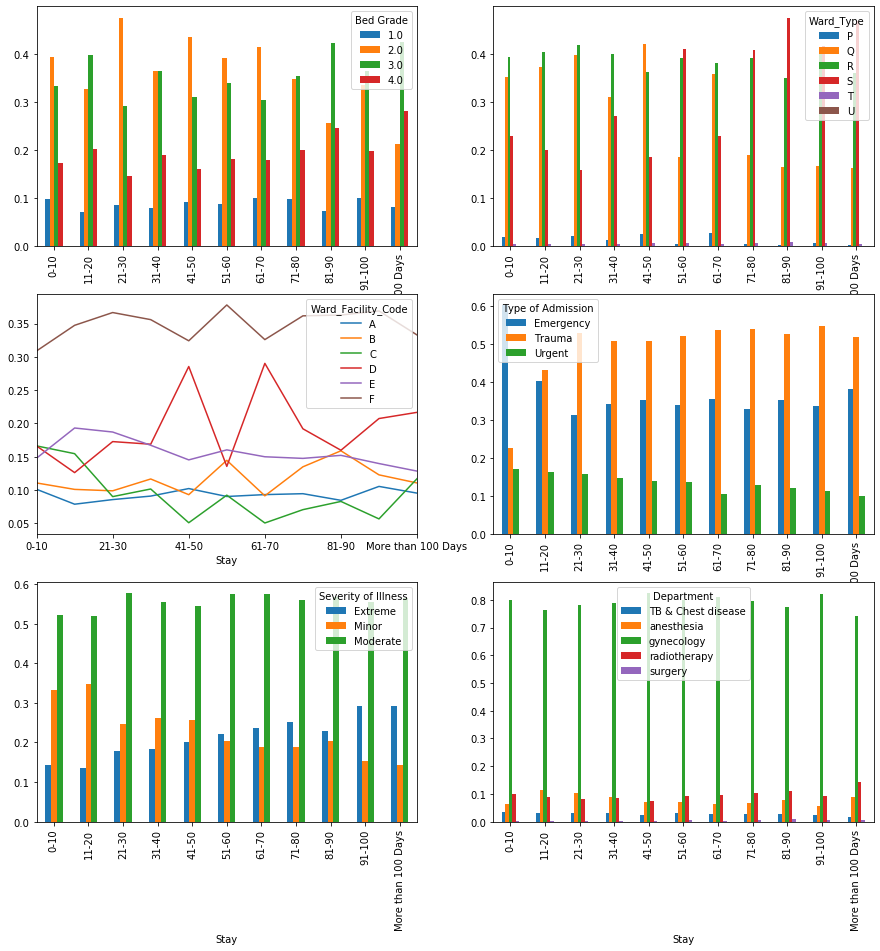

In [11]:
fig, axs = plt.subplots(3,2)

perc_stacked_graph(train, y, "Bed Grade", id_, axs = axs[0,0])
perc_stacked_graph(train, y, "Ward_Type", id_, axs = axs[0,1])
perc_stacked_graph(train, y, "Ward_Facility_Code", id_, axs = axs[1,0], kind='line')
perc_stacked_graph(train, y, "Type of Admission", id_, axs = axs[1,1], kind='bar')
perc_stacked_graph(train, y, "Severity of Illness", id_, axs = axs[2,0], kind='bar')
perc_stacked_graph(train, y, "Department", id_, axs = axs[2,1], kind='bar')

In [8]:
def clean_data(dataset):
    
    #dataset.loc[dataset['City_Code_Patient'].isnull(), 'City_Code_Patient'] = statistics.mode(train['City_Code_Patient'])
    #dataset.loc[dataset['Bed Grade'].isnull(), 'Bed Grade'] = statistics.mode(train['Bed Grade'])
    
    #dataset['Hospital_code'] = dataset['Hospital_code'].astype(str)
    #dataset['City_Code_Hospital'] = dataset['City_Code_Hospital'].astype(str)
    #dataset['City_Code_Patient'] = dataset['City_Code_Patient'].astype(str)
    
    dataset = dataset.fillna(-1)
    
    #dataset = dataset.dropna()
    dataset = dataset.drop(['patientid', 'case_id', 'City_Code_Patient'], axis=1)
    return dataset
#train1 = clean_data(train)
#test1 = clean_data(test)

In [9]:


cols = ['Hospital_region_code', 'Department', 'Type of Admission', 'Severity of Illness']
def add_features(dataset, cols):
    for col in cols:
        temp = dataset.groupby(col).agg({'Available Extra Rooms in Hospital':['count','mean','sum','min','max'],
                                 'Bed Grade':['count','mean','sum'],
                                  'Visitors with Patient':['count','mean','sum'],
                                  'Admission_Deposit':['mean','sum','min','max'],
                                'Hospital_code':['mean','sum','min','max', 'nunique'],
                                'City_Code_Hospital':['mean','sum','min','max', 'nunique']
                                #'City_Code_Patient':['mean','sum','min','max']
                                 })
        temp.columns = [('_'+col+'_').join(x) for x in temp.columns]
        dataset = pd.merge(dataset,temp,on=[col],how='left')
    return dataset

In [10]:


def add_features_2(dataset):
    Total_hospitals_in_city = pd.DataFrame(dataset.groupby(['City_Code_Hospital'])['Hospital_code'].nunique())
    max_hospital_room       = pd.DataFrame(dataset.groupby(['Hospital_code'])['Available Extra Rooms in Hospital'].max())
    Total_hospitals_in_city.columns = ['Total_hospitals_in_city']

    ## Add the column to train and test
    dataset = pd.merge(dataset,
             Total_hospitals_in_city,
             on = 'City_Code_Hospital',
             how = 'left')
    
    max_hospital_room.columns = ['Total Rooms']

    ## Add Current hospital capacity to Train and Test
    dataset = pd.merge(dataset,
             max_hospital_room,
             on = 'Hospital_code',
             how = 'left')
    dataset['Current_Hospital_Capacity'] = (dataset['Total Rooms'] - dataset['Available Extra Rooms in Hospital'])/dataset['Total Rooms']

    return dataset

def change_features_2(dataset):
    
    dataset['Age'] = dataset['Age'].astype('category')
    dataset['Age'] = dataset['Age'].cat.reorder_categories(['0-10','11-20','21-30','31-40','41-50','51-60','61-70','71-80','81-90','91-100'])
    dataset['Age'] = pd.Categorical(dataset['Age'], ordered = True)
    dataset['Age'] = dataset['Age'].cat.codes
    
    dataset['Severity of Illness'] = dataset['Severity of Illness'].astype('category')
    dataset['Severity of Illness'] = dataset['Severity of Illness'].cat.reorder_categories(['Minor','Moderate','Extreme'])
    dataset['Severity of Illness'] = pd.Categorical(dataset['Severity of Illness'], ordered = True)
    dataset['Severity of Illness'] = dataset['Severity of Illness'].cat.codes
    return dataset



In [11]:
def impute_num_missing(dataset, id_):
    numeric_colnames = dataset._get_numeric_data().columns
    imputed_training=fast_knn(dataset._get_numeric_data().values, k=10)
    imputed_training = pd.DataFrame(imputed_training, columns = numeric_colnames)
    imputed_training.head()

    dataset = dataset.drop(dataset.drop(id_, axis=1)._get_numeric_data().columns, axis=1)
    dataset = pd.merge(dataset, imputed_training, how='left', on = [id_])
    return dataset


In [12]:
def impute_num_missing2(dataset, id_):
    numeric_colnames = dataset._get_numeric_data().columns
    imputer = KNNImputer(n_neighbors=3)
    imputed_training = imputer.fit_transform(train._get_numeric_data().values)
    imputed_training = pd.DataFrame(imputed_training, columns = train._get_numeric_data().columns)
    dataset = dataset.drop(dataset.drop(id_, axis=1)._get_numeric_data().columns, axis=1)
    dataset = pd.merge(dataset, imputed_training, how='left', on = [id_])
    return dataset


In [13]:

def encode_dataset(dataset):
#cat_cols = train.select_dtypes(include=['object']).columns
    cat_cols = ['Hospital_type_code', 'Hospital_region_code', 'Department', 'Ward_Type', 'Ward_Facility_Code', 'Type of Admission']
    le = LabelEncoder()
    for col in cat_cols:
        dataset[col] = le.fit_transform(dataset[col])
        
    
    return dataset
    

In [61]:
train1 = encode_dataset(train)
train1.head()

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,2,3,2,3,3,2,5,2.0,31397,7.0,0,Extreme,2,51-60,4911.0,0-10
1,2,2,2,5,2,2,3,3,5,2.0,31397,7.0,1,Extreme,2,51-60,5954.0,41-50
2,3,10,4,1,0,2,1,3,4,2.0,31397,7.0,1,Extreme,2,51-60,4745.0,31-40
3,4,26,1,2,1,2,3,2,3,2.0,31397,7.0,1,Extreme,2,51-60,7272.0,41-50
4,5,26,1,2,1,2,3,3,3,2.0,31397,7.0,1,Extreme,2,51-60,5558.0,41-50


In [82]:
#train.loc[train['City_Code_Patient'].isna(),]
train.loc[train['patientid']==122110]


,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
191,192,14,a,1,X,2,radiotherapy,Q,E,3.0,122110,NaN,Emergency,Minor,2,71-80,9096.0,51-60
192,193,30,c,3,Z,2,anesthesia,Q,A,4.0,122110,NaN,Trauma,Minor,2,71-80,5098.0,31-40
193,194,27,a,7,Y,2,radiotherapy,P,C,3.0,122110,NaN,Trauma,Minor,2,71-80,7776.0,21-30
194,195,27,a,7,Y,2,anesthesia,Q,C,3.0,122110,NaN,Trauma,Minor,2,71-80,5988.0,11-20
195,196,25,e,1,X,3,radiotherapy,S,E,3.0,122110,NaN,Urgent,Minor,2,71-80,5333.0,21-30


In [139]:
test.isna().sum()

case_id                                 0
Hospital_code                           0
Hospital_type_code                      0
City_Code_Hospital                      0
Hospital_region_code                    0
Available Extra Rooms in Hospital       0
Department                              0
Ward_Type                               0
Ward_Facility_Code                      0
Bed Grade                              35
patientid                               0
City_Code_Patient                    2157
Type of Admission                       0
Severity of Illness                     0
Visitors with Patient                   0
Age                                     0
Admission_Deposit                       0
dtype: int64

In [14]:
def create_test_train(dataset):
    X = dataset.drop('Stay', axis=1)
    Y = dataset['Stay']
    X_train, X_test, y_train, y_test = train_test_split(X, Y,test_size=0.2, random_state=2020, stratify=Y)
    return(X_train, X_test, y_train, y_test)

#X_train, X_test, y_train, y_test = create_test_train(train1)
#X_train.shape

In [15]:
def get_imp_df(estimator, df):
    imp_df = []
    for col, imp in zip(df.columns, estimator.feature_importances_):
        imp_df.append([col,imp])
    imp_df = pd.DataFrame(imp_df, columns=['Feature', 'Importance'])
    imp_df = imp_df.sort_values('Importance', ascending = False).reset_index(drop=True)
    return imp_df

In [17]:
X_train_dum = pd.get_dummies(X_train)
X_test_dum = pd.get_dummies(X_test)

In [ ]:
rf = RandomForestClassifier(n_estimators = 300, n_jobs=-1, random_state= 2020, verbose=0)
rf = rf.fit(X_train_dum, y_train)
pred = rf.predict(X_test_dum)
print("Accuracy Score: ", accuracy_score(y_test, pred))

In [22]:
test.shape[0]/(test.shape[0] + train.shape[0])

0.3008968265293801

In [16]:
train, test = get_datasets()
train1 = train.copy()
#train1 = impute_num_missing2(train1, id_='case_id')
train1 = clean_data(train1)
train1 = encode_dataset(train1)
#train1 = add_features(train1, cols)
#train1 = add_features_2(train1)
train1 = change_features_2(train1)
X_train, X_test, y_train, y_test = create_test_train(train1)
X_train_dum = pd.get_dummies(X_train, drop_first=True)
X_test_dum = pd.get_dummies(X_test, drop_first=True)

In [74]:


cb = CatBoostClassifier(learning_rate=0.1,
                        depth=5,
                        boosting_type='Plain',
                        eval_metric='Accuracy',
                        n_estimators=1000,
                        random_state=1, 
                        task_type = 'GPU',
                        l2_leaf_reg = 10,
                        #random_strength = 0.1,
                        #auto_class_weights = 'SqrtBalanced',
                        
                        verbose=0)
cb.fit(X_train_dum, y_train)
pred = cb.predict(X_test_dum)
print("Accuracy Score: ", accuracy_score(y_test, pred))
print("F1 Score:", f1_score(y_test, pred, average='weighted'))

Accuracy Score:  0.41891722145459115
F1 Score: 0.3847641375686609


In [25]:
    
Accuracy Score:  0.42491521165682705
F1 Score: 0.3900437599354799
    
0.42597874408451375

Accuracy Score:  0.4273490654726812
F1 Score: 0.3926828190177813

0.4274745634970481

In [43]:
acc

0.0

In [66]:
cv_sss = StratifiedShuffleSplit(n_splits=5, test_size = 0.5, random_state=1)
scores = []

avg_loss = []
for i, (idxT, idxV) in enumerate(cv_sss.split(X_train_dum, y_train)):
    print("fold: ", i)
    cb.fit(X_train_dum.iloc[idxT], y_train.iloc[idxT],
                eval_set=[(X_train_dum.iloc[idxV],y_train.iloc[idxV])],
               early_stopping_rounds=50,verbose = 0)
    
    acc = accuracy_score(y_train.iloc[idxV],cb.predict(X_train_dum.iloc[idxV]))*100
    
    scores.append(acc)
    
    avg_loss.append(cb.best_score_['validation']['MultiClass'])
    
    print ('CatBoost Val CV=',acc)
    
print("Multi Log Loss Stats {0:.5f},{1:.5f}".format(np.array(avg_loss).mean(), np.array(avg_loss).std()))

print('%.3f (%.3f)' % (np.array(scores).mean(), np.array(scores).std()))

fold 1: 
CatBoost Val CV= 41.67379784102061
fold 1: 
CatBoost Val CV= 41.75073601570167
fold 1: 
CatBoost Val CV= 41.89283611383709
fold 1: 
CatBoost Val CV= 41.766437684003925
fold 1: 
CatBoost Val CV= 41.843375858684986
Multi Log Loss Stats 1.51886,0.00142
41.785 (0.076)


In [ ]:
41.714
41.785

In [112]:
cb_params = {'learning_rate':[0.05,0.06,0.07,0.08,1],
            'depth':[3,5,7,8],
            'n_estimators':[1000,2000,4000]}

In [115]:

gs = GridSearchCV(estimator = cb, param_grid=cb_params, cv=2, verbose=2)
gs.fit(X_train_dum, y_train)
gs.best_params_

Fitting 2 folds for each of 60 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] depth=3, learning_rate=0.05, n_estimators=1000 ..................
[CV] ... depth=3, learning_rate=0.05, n_estimators=1000, total=  11.7s
[CV] depth=3, learning_rate=0.05, n_estimators=1000 ..................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.6s remaining:    0.0s


[CV] ... depth=3, learning_rate=0.05, n_estimators=1000, total=  11.2s
[CV] depth=3, learning_rate=0.05, n_estimators=2000 ..................
[CV] ... depth=3, learning_rate=0.05, n_estimators=2000, total=  21.9s
[CV] depth=3, learning_rate=0.05, n_estimators=2000 ..................
[CV] ... depth=3, learning_rate=0.05, n_estimators=2000, total=  21.2s
[CV] depth=3, learning_rate=0.05, n_estimators=4000 ..................
[CV] ... depth=3, learning_rate=0.05, n_estimators=4000, total=  41.8s
[CV] depth=3, learning_rate=0.05, n_estimators=4000 ..................
[CV] ... depth=3, learning_rate=0.05, n_estimators=4000, total=  43.6s
[CV] depth=3, learning_rate=0.06, n_estimators=1000 ..................
[CV] ... depth=3, learning_rate=0.06, n_estimators=1000, total=  11.2s
[CV] depth=3, learning_rate=0.06, n_estimators=1000 ..................
[CV] ... depth=3, learning_rate=0.06, n_estimators=1000, total=  11.2s
[CV] depth=3, learning_rate=0.06, n_estimators=2000 ..................
[CV] .

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 90.5min finished


{'depth': 7, 'learning_rate': 0.05, 'n_estimators': 1000}

In [19]:
rus = RandomUnderSampler(random_state=0, sampling_strategy='majority')
X_train_dum_us, y_train_us = rus.fit_resample(X_train_dum, y_train)

In [20]:

y_train_us.value_counts()

11-20                 62511
31-40                 44127
51-60                 28014
0-10                  18883
41-50                  9394
71-80                  8203
More than 100 Days     5347
81-90                  3871
91-100                 2212
61-70                  2195
21-30                  2195
Name: Stay, dtype: int64

In [21]:
X_train_dum_us, y_train_us = rus.fit_resample(X_train_dum, y_train)


In [35]:
# Submission file


test1 = clean_data(test)
test1 = add_features(test1, cols)
test1 = pd.get_dummies(test1)
#test1 = test1[imp_df.head(50)['Feature']]


final_pred = cb.predict(test1)
final_sub_df = pd.DataFrame(test['case_id'])
final_sub_df['Stay'] = final_pred
final_sub_df.head()
final_sub_df.to_csv("cat7.csv", index=False)


In [148]:
# Full DF Submission

num_feat = 40

full_df_dum = pd.concat([X_train_dum, X_test_dum])
full_df_y = pd.concat([y_train, y_test])

#full_df_dum = full_df_dum[imp_df.head(num_feat)['Feature']]

cb = CatBoostClassifier(learning_rate=0.05,
                        depth=7,
                        boosting_type='Plain',
                        eval_metric='Accuracy',
                        n_estimators=1000,
                        random_state=294, 
                        task_type = 'GPU',
                        l2_leaf_reg = 10,
                        verbose=0)
cb.fit(full_df_dum, full_df_y)

test1 = test.copy()
#test1 = impute_num_missing2(test1, id_='case_id')
test1 = clean_data(test1)

test1 = add_features_2(test1)
test1 = change_features_2(test1)
test1 = add_features(test1, cols)
test1 = pd.get_dummies(test1, drop_first=True)
#test1 = test1[[full_df_dum.columns]]
#test1 = test1[imp_df.head(num_feat)['Feature']]
#test1 = ar_test

final_pred = cb.predict(test1)
final_sub_df = pd.DataFrame(test['case_id'])
final_sub_df['Stay'] = final_pred
final_sub_df.head()
final_sub_df.to_csv("cat19.csv", index=False)

In [136]:
test1.shape

(137057, 152)

In [23]:
acc_df = []

for i in range(10, 110, 10):
    print(i)
    top_feat = imp_df.head(i)['Feature']
    X_train_dum1 = X_train_dum[top_feat]
    X_test_dum1 = X_test_dum[top_feat]

    cb = CatBoostClassifier(learning_rate=0.1,
                        depth=5,
                        boosting_type='Plain',
                        eval_metric='Accuracy',
                        n_estimators=1000,
                        random_state=294, 
                        task_type = 'GPU',
                        l2_leaf_reg = 10,
                        verbose=0)
    #cb.fit(X_train_dum1, y_train)
    pred = cb.predict(X_test_dum1)
    acc_df.append([i, accuracy_score(y_test, pred)])
    #print("Accuracy Score: ", accuracy_score(y_test, pred))

10
20
30
40
50
60
70
80
90
100


In [32]:
X_train_dum = X_train_dum[imp_df.head(40)['Feature']]
X_test_dum = X_test_dum[imp_df.head(40)['Feature']]

In [137]:
imp_df = get_imp_df(cb, X_train_dum)
imp_df.head(50)

,Feature,Importance
0,Visitors with Patient,28.805895
1,City_Code_Patient,6.568777
2,Admission_Deposit,6.026202
3,Ward_Type_S,5.536177
4,Ward_Type_Q,5.452967
5,Age,5.235811
6,Bed Grade,5.056152
7,Available Extra Rooms in Hospital,4.043277
8,Hospital_code,3.523787
9,Ward_Type_R,3.291711


In [140]:
lgb1 = lgb.LGBMClassifier(learning_rate = 0.25,
                            max_depth = 3,
                          n_estimators = 300,
                          verbose= 10,
                          min_data_in_leaf=20,
                          boosting = 'gbdt'
                         )


In [138]:
lgb1.fit(X_train_dum, y_train)
pred = lgb1.predict(X_test_dum)
print("Accuracy Score: ", accuracy_score(y_test, pred))

Accuracy Score:  0.42304672779801533


In [75]:
train.head(100)

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50
5,6,23,a,6,X,2,anesthesia,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,4449.0,11-20
6,7,32,f,9,Y,1,radiotherapy,S,B,3.0,31397,7.0,Emergency,Extreme,2,51-60,6167.0,0-10
7,8,23,a,6,X,4,radiotherapy,Q,F,3.0,31397,7.0,Trauma,Extreme,2,51-60,5571.0,41-50
8,9,1,d,10,Y,2,gynecology,R,B,4.0,31397,7.0,Trauma,Extreme,2,51-60,7223.0,51-60
9,10,10,e,1,X,2,gynecology,S,E,3.0,31397,7.0,Trauma,Extreme,2,51-60,6056.0,31-40
